<a href="https://pangeos.eu/" target="_blank">
<center><img src="../images/1-logos.png" alt="logos" width="100%"/></center>
</a>

PANGEOS summer taining school 2024

EXAMPLE OF UNCERTAINTY PROPAGATION FOR 

# CASE 1: "Ground based reflectance retrieval using a dual-field-of-view spectrometer system"

**Authors:**
L. Mihai (laura.mihai@inflpr.ro) and A. Bialek (agnieszka.bialek@npl.co.uk)

# Learning objectives

**After follwing this notebook you will be able to ...**
- Explain the two uncertainty ($U_T$) components, random $U_R$ and systematic $U_S$
- Compute $U_R$ from measurement repetitions
- Assign the magnitude of $U_S$ 
- Propagate both uncertainty components through functions and models with `punpy`
- Compute and explain error correlation matrix

# Prerequisites

- Understanding of Piccolo spectrometer data processing explained in [case_1-Ex0-Piccolo.ipynb](case_1-Ex0-Piccolo.ipynb)

*code from this notebook is provided below without any explanation, pease refer to the respective notebook if something is unclear*

<span style="color:red">
This notebook demonstrates radiance (L) component. The irradiance component (E) is your self-study
</span>

# TOC

1. [Introduction](#1)
2. [Piccolo data reading](#2)
3. [Uncertainty quantification steps (theory)](#3)
   1. [Step 1](#Step-1): Trace the traceability chain
   2. [Step 2](#Step-2): Take Your Measurements & Write down the measurement equation
   3. [Step 3](#Step-3): Estimate the uncertainty of each input quantity that feeds into the final result
   4. [Step 4](#Step-4): Assess Independence of Input Quantities
   5. [Step 5](#Step-5): Calculate the Measurement Result
   6. [Step 6](#Step-6): Find the Combined Standard Uncertainty - u_c
   7. [Step 7](#Step-7): Propagate Input Uncertainty
   8. [Step 8](#Step-8): Document the Measurement Result and Uncertainty
4. [Propagation of uncertainty (practice)](#4)
   1. [4-0](#4-0) Monte Carlo sampler definition
   2. [4-1](#4-1) model function definition
   3. [4-2](#4-2) mean value computation
   4. [4-3](#4-3) random uncertainty (U$_R$)
   5. [4-4](#4-4) systematic uncertainty (U$_S$)
   6. [4-5](#4-5) total uncertainty (U$_T$)
5. [Correlation and covariance matrices](#5)
   1. [5-1](#5-1) random uncertainty (U$_R$)
   2. [5-2](#5-2) systematic uncertainty (U$_S$)
   3. [5-3](#5-3) total uncertainty covariance matrix (U$_T$)
   4. [5-4](#5-4) total uncertainty correlation matrix (U$_T$)
   5. [5-5](#5-5) interpretation of total uncertainty correlation matrix (U$_T$)
6. [Assignment](#6)

# 1
## Introduction

In this notebook we present a simple example on how to propagate uncertainties for a field reflectance measurement using **METHOD 1**, taking into account only the **uncertainty from the instrument calibration certificate**. 

**METHOD 1** is based on field reflectance measurements using a spectrometer system (Piccolo doppio) with dual-field-of-view having a cosine diffuser fore optic to capture down-welling irradiance and a view angle limited fore optic to capture up-welling radiance, measuring reflectance across the 400 nm to 1,000 nm (VNIR) spectral range. Thus, the calibration for **two** systems is considered: 
1. the one measuring the spectral irradiance 
2. that one measuring the spectral radiance.

The propagation of uncertainties within this session will be done using the **Comet-toolkit** together with the punpy tool. The **CoMet Toolkit** (Community Metrology Toolkit) is an open-source software project to develop Python tools for the handling of error-covariance information in the analysis of measurement data. *punpy* is a tool for “Propagation of UNcertainties in Python” and has been developed by Pieter De Vis from NPL. *punpy* propagates uncertainties on input quantities through any python function, evaluating the uncertainty on the output. These input data uncertainties can be defined using obsarray.

Details about Comet-toolkit and punpy you can find here: 
https://punpy.readthedocs.io/en/latest/ ; https://www.comet-toolkit.org/about/

<table>
    <tr>
        <td> 
            <a href="https://punpy.readthedocs.io/en/latest/" target="_blank">
                <center><img src="../images/logo-punpy.webp" alt="logo-punpy" width="40%"/></center>
            </a>
        <td> 
            <a href="https://www.comet-toolkit.org/about/" target="_blank">
                <center><img src="../images/logo-comet.svg" alt="logo-comet" width="50%"/></center>
            </a>
    </tr>
    </table>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import punpy

from pathlib import Path

plt.rcParams.update({'font.size': 16})

# 2
## Piccolo data reading

For details on data reading, please, refer to the notebook [case_1-Ex0-Piccolo.ipynb](case_1-Ex0-Piccolo.ipynb)

Reflectance measurements using a spectrometer system (Piccolo doppio)

[back to TOC](#TOC)

In [2]:
data_dir = Path(r'../data/case1-set1')

data = {}

for path_txt in data_dir.glob("*.txt"):
    key = path_txt.name.replace('.txt', '')
    with open(path_txt, "r") as f:
        data[key] = np.loadtxt(f)

In [3]:
# common inputs
pi = np.pi;
Wvl = data['WavelengthS2_Rad']

#### Radiance (L)

In [4]:
# your data for Radiance sensor
DataL0_Rad = data['S2_lg_Rad']  # light signal (measurement)
N_L = DataL0_Rad.shape[1] # the number of light measurements
print(N_L, 'repetitions of light measurements')

Datadark_Rad = data['S2_dk_Rad']  # dark signal (noise)
M_L = Datadark_Rad.shape[1]  # the number of dark measurements
print(M_L, 'repetitions of dark noise measurements')

IT_Rad = data['S2_IT_Rad']  # integration time
print(IT_Rad, 'ms integration time')

cal_coef_L0 = data['CcalS2_L']  # calibration coefficients from lab calibration

20 repetitions of light measurements
20 repetitions of dark noise measurements
65.0 ms integration time


#### Irradiance (E)

In [5]:
# data for Irradiance sensor
DataE0_Irrad = data['S2_lg_Irrad']
N_E = DataE0_Irrad.shape[1]
print(N_E, 'repetitions of light measurements')

Datadark_Irrad = data['S2_dk_Irrad']
M_E = Datadark_Irrad.shape[1]
print(M_E, 'repetitions of dark measurements')

IT_Irrad = data['S2_IT_Irrad']
print(IT_Irrad, 'ms integration time')

cal_coef_E0 = data['CcalS2_E'] 

20 repetitions of light measurements
20 repetitions of dark measurements
58.0 ms integration time


#### Integration time correction

In [6]:
def integration_time_normalisation(DN, IT):
    return DN / IT 

In [7]:
L0 = integration_time_normalisation(DataL0_Rad, IT_Rad)
dark_L0 = integration_time_normalisation(Datadark_Rad, IT_Rad)

E0 = integration_time_normalisation(DataE0_Irrad, IT_Irrad)
dark_E0 = integration_time_normalisation(Datadark_Irrad, IT_Irrad)

this is the time to average raw measurements

later we are going to compute radom uncertainty from this repetitions but now we keep them as is

In [8]:
L0_m = np.mean(L0, axis=1)
dark_L0_m = np.mean(dark_E0, axis=1)

E0_m = np.mean(E0, axis=1)
dark_E0_m = np.mean(dark_E0, axis=1)


#### Calibration coefficients application and nark noise subtraction
**the calibration functions for radiance and irradiance sensors**

[back to TOC](#TOC)

In [9]:
def calibrate(light_meas, dark_meas, cal_coef):
    return (light_meas - dark_meas) * cal_coef

In [10]:
L1 = calibrate(L0_m, dark_L0_m, cal_coef_L0) # calibration coefficients for signal without nonlin applied

E1 = calibrate(E0_m, dark_E0_m, cal_coef_E0) # calibration coefficients for signal without nonlin applied

### Notice how the units are changing from Level 0 to Level 1

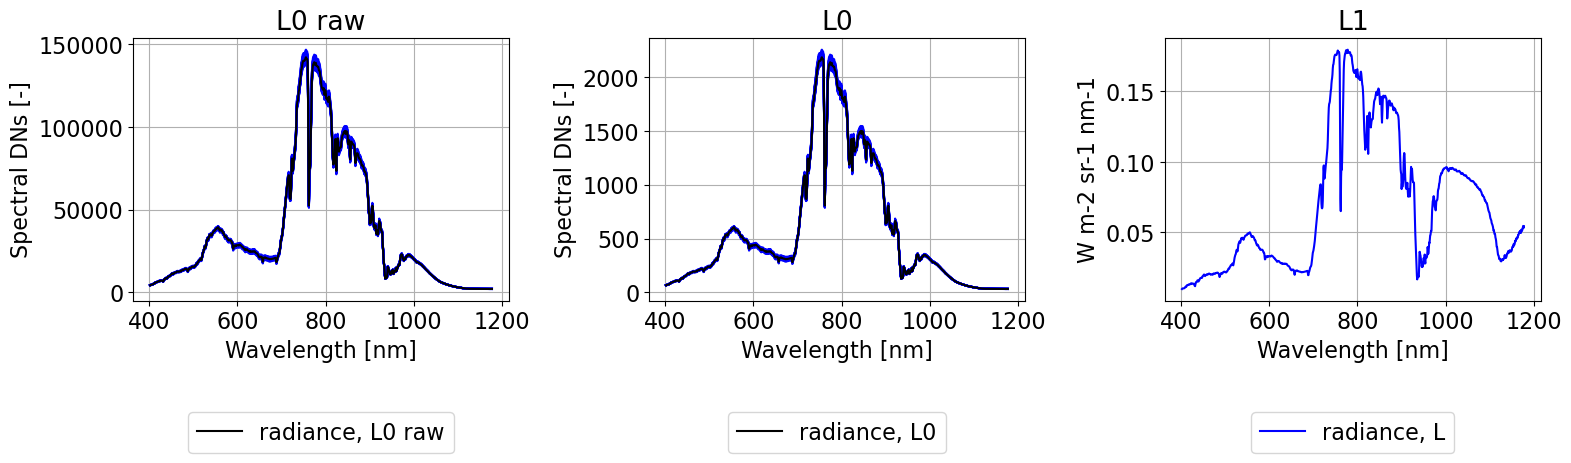

In [11]:
_, axs = plt.subplots(1, 3, figsize=(16, 4.5), tight_layout=True, sharex=True)

ax = axs[0]
ax.plot(Wvl, DataL0_Rad, 'b')
ax.plot(Wvl, DataL0_Rad.mean(axis=1), 'k', label='radiance, L0 raw')
ax.set_title('L0 raw')
ax.set_ylabel('Spectral DNs [-]')


ax = axs[1]
ax.plot(Wvl, L0, 'b')
ax.plot(Wvl, L0_m, 'k', label='radiance, L0')
ax.set_title('L0')
ax.set_ylabel('Spectral DNs [-]')


ax = axs[2]
ax.plot(Wvl, L1, 'b', label='radiance, L')
ax.set_title('L1')
ax.set_ylabel('W m-2 sr-1 nm-1')

for ax in axs:
    ax.set_xlabel('Wavelength [nm]')
    ax.grid()
    ax.legend(bbox_to_anchor=[0.5, -0.5], loc='center')

<span style="color:red">
The task of uncertainty propagation is to come up with the confidence inter around the L1 curve
</span>

# 3
## Uncertainty quantification steps (theory)

[back to TOC](#TOC)

# 3. Take the checklist for uncertainty analysis steps and try to follow each step. 
*NOTE! You have it printed on table.*

## Step 1
**STEP 1 - Trace the traceability chain**: at the base of traceability chain is your instrument (in this case spectrometer system (Piccolo doppio) with dual-field-of-view, 1 with cosine diffuser FO and 1 with FOV 25%). This instrument it is calibrated using two secondary standards (by NMI in your country or a metrology lab. with traceability to SI): one radiance standard (that can be an integrating sphere or an irradiance standard with a reflectance panel) and one is the irradiance standard. The secondary standards are calibrated agains primary standards (in general cryogenic radiometer) that defines the unit of spectral radiance (W/m2 sr nm) or irradiance (W/m2 nm).

 - Interactive Task: Create a simple flowchart showing how your instrument connects to the primary standard. What are the intermediate standards involved? This visual representation will help clarify the chain of accuracy!

[back to TOC](#TOC)

## Step 2
**STEP 2 - Take Your Measurements & Write down the measurement equation**. 

- What to Do: Conduct your measurements and write down the measurement equation you’ll be using.
Since you need to derive the absolute reflectance, your equation will be:
   
$R_{abs} = \dfrac{\pi \cdot L [SI units]}{E [SI units]}$

- Interactive Task: Record your measurements in a table. What did you measure, and what units did you use? Share your measurement equation with a peer to compare!

[back to TOC](#TOC)

## Step 3
**STEP 3 - Estimate the uncertainty of each input quantity that feeds into the final result**. 

- What to Do: Determine the uncertainty for each input quantity that contributes to your final result. This includes Type A (statistical) and Type B (non-statistical) uncertainties. Express all uncertainties in similar terms (standard uncertainties, u).
  
Interactive Task: Sketch a tree diagram to visualize how each input feeds into the final result. 

<center><img src="../images/1-u-tree-diagram.png" alt="logos" width="100%"/></center>

[back to TOC](#TOC)

What uncertainties did you identify? How do they interconnect? Separate then in systematic and random uncertainties.

## Step 4
**STEP 4 - Assess Independence of Input Quantities**

- What to Do: Decide whether the errors of your input quantities are independent of each other. If not, you may need additional calculations or information.
- Interactive Task: Discuss with a partner: Do you think any of your input uncertainties influence each other? How would you handle that?

[back to TOC](#TOC)

## Step 5
**Step 5: Calculate the Measurement Result**

- What to Do: Calculate your measurement result, including any necessary corrections (e.g., calibration adjustments). Also, determine the sensitivity coefficients for each input.
- Interactive Task: Share your calculations with a classmate. Do your results match? - What corrections did you apply, and why?

[back to TOC](#TOC)

## Step 6
**Step 6: Find the Combined Standard Uncertainty - u_c**

- What to Do: Combine the uncertainties from all individual aspects to find the overall standard uncertainty. Assign uncertainties appropriately based on your earlier steps.
- Interactive Task: Create a list of all uncertainties and their contributions to the combined standard uncertainty. How do these uncertainties impact the overall result?

[back to TOC](#TOC)

## Step 7
**Step 7: Propagate Input Uncertainty**

- What to Do: Use your measurement equation to propagate the input uncertainties. This will help you understand how uncertainties combine and affect your final measurement.
  
  Expanded uncertainty **U** = coverage factor **k** x combined standard uncertainty **u_total**.
  
    • k = 2 for confidence level of 95 % (Most common)
  
    • k = 1 confidence level of approximately 68 %
  
    • k = 2.58 confidence level of 99 %
  
    • k = 3 confidence level of 99.7 %

- Interactive Task: Work in small groups to practice propagating uncertainties using different measurement equations. Can you find any patterns in how uncertainties propagate?

[back to TOC](#TOC)

## Step 8
**Step 8: Document the Measurement Result and Uncertainty**

- What to Do: Write down your final measurement result and the associated uncertainty in a document. Be sure to express the uncertainty using a coverage factor or by stating the size of the uncertainty interval, along with the level of confidence.

` Result = Measured Value ± Uncertainty U`
  
- Interactive Task: Present your findings to the group. How did you express the uncertainty? What level of confidence did you achieve? Engage in a discussion about different ways to communicate uncertainty.

[back to TOC](#TOC)

# 4
## Propagation of uncertainty (practice)

[back to TOC](#TOC)

We are propagating the uncertainty of measured quantiles (light and dark measurements, calibration coefficients) to the calibrated **radiance (L)**.

The propagation is done through a function:

```python
def calibrate(light_meas, dark_meas, cal_coef):
    return (light_meas - dark_meas) * cal_coef
```

Analysis of the function `calibrate` shows that we have to conduct two mathematical operations to come from raw measurements to calibrated radiance
- subtraction [of dark (noise) measurement from the light measurement]
- multiplication [by the calibration coefficient]

In such simple case of two mathematical operations we could propagate the uncertainties analytically by hand https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Example_formulae. This requires computations of covariances, which is done with help of partical derivatives assembled in a Jacobian matrix. An example on how to use the Low of Propagation Uncertainties (LPU) is given here: https://github.com/comet-toolkit/comet_training/blob/main/punpy_standalone_example_LPUdetail.ipynb

<a href="https://dictionary.helmholtz-uq.de/content/monte_carlo_method.html#fig-monte-carlo-method-1" target="_blank">
<img align="right" src="../images/monte-carlo-method-1.png" alt="" width="50%"/> 
</a>


We, however, will use a numerical solution with the **Monte Carlo (MC)** method. This is a common method to propagate uncertainty through more complex functions and models (see follow-up notebooks).

Monte Carlo (MC) samples input values from their distributions, runs the function (model) and assembles the output disttibution. 

Our intputs
- light measurements
- dark measurements
- calibration coefficients

Our output
- radiance in absolute values

MC sampling is done from with a probability density function (PDF) (gaussian, rectangular) defined by its mean and standard deviation.

More on punpy realization of the Monte Carlo uncertainty propagation is https://punpy.readthedocs.io/en/latest/content/atbd.html#monte-carlo-method


## 4-0
### MC sampler definition

[back to TOC](#TOC)

for rubustness we will draw 10 000 samples from the PDFs

In [12]:
prop = punpy.MCPropagation(10000)

## 4-1
### model function definition

[back to TOC](#TOC)

In [13]:
def calibrate(light_meas, dark_meas, cal_coef):
    return (light_meas - dark_meas) * cal_coef

## 4-2
### mean value computation

[back to TOC](#TOC)

In [14]:
L0_m = np.mean(L0, axis=1)
dark_L0_m = np.mean(dark_L0, axis=1)

L1 = calibrate(L0_m, dark_L0_m, cal_coef_L0)

## 4-3 
### random uncertainty $U_R$

[back to TOC](#TOC)

$U_R = \dfrac{\sigma}{\sqrt N}$

random uncertainties are uncorrelated

### 4-3-1
#### random uncertainty computation

In [15]:
L0_ur = np.std(L0, axis=1) / (N_L**0.5) 

dark_L0_ur = np.std(dark_L0, axis=1) / (M_L**0.5)

### 4-3-2
#### random uncertainty propagation

function help https://punpy.readthedocs.io/en/latest/content/generated/punpy.mc.mc_propagation.MCPropagation.propagate_random.html#punpy.mc.mc_propagation.MCPropagation.propagate_random

Notice three argiments of the `.propagate_random()` function:
- the function `calibrate` we want to propagate uncertainty through
- the inputs of this function `[L0_m, dark_L0_m, cal_coef_L0]`
- the random uncertainties associated with those inputs `[L0_ur, dark_L0_ur, np.zeros(1036)]`

For calibration coefficients we assume no random uncertainties

In [16]:
L1_ur = prop.propagate_random(calibrate,
                              [L0_m, dark_L0_m, cal_coef_L0],
                              [L0_ur, dark_L0_ur, np.zeros(len(Wvl))])  

### 4-3-3
#### plotting random uncertainty

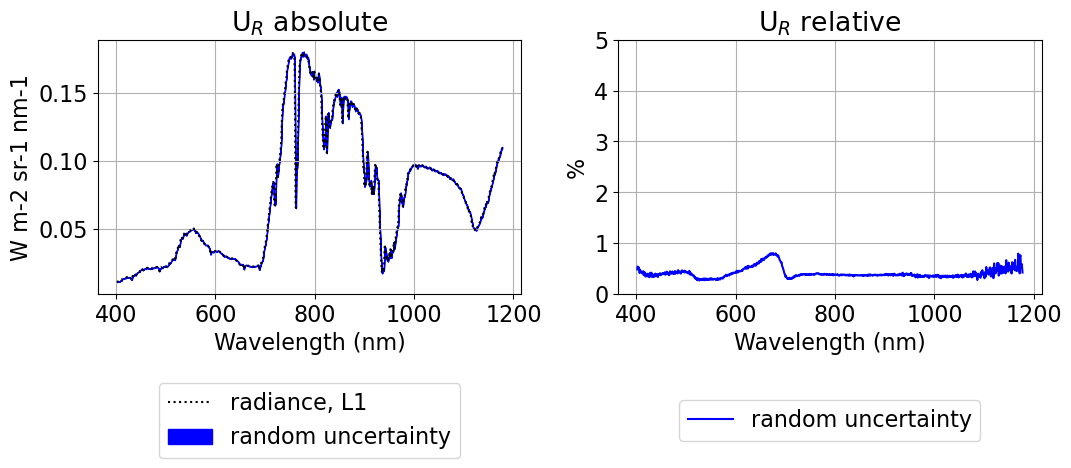

In [17]:
_, axs = plt.subplots(1, 2, figsize=(11, 4.5), tight_layout=True)

x = L1
ur = L1_ur
c = 'blue'
utype = 'random'

ax = axs[0]
ax.plot(Wvl, x, color="black", linestyle=':', label='radiance, L1')
ax.fill_between(Wvl, x - ur, x + ur, color=c, alpha=1, label=f"{utype} uncertainty")
ax.set_title(f"U$_R$ absolute")
ax.set_ylabel('W m-2 sr-1 nm-1')

ax = axs[1]
ax.plot(Wvl, ur / x * 100, color=c, label=f"{utype} uncertainty")
ax.set_title(f"U$_R$ relative")
ax.set_ylabel('%')
ax.set_ylim([0, 5])

for ax in axs:
    ax.set_xlabel("Wavelength (nm)")
    ax.grid()
    ax.legend(bbox_to_anchor=[0.5, -0.5], loc='center')

## 4-4
### systematic uncertainty $U_S$

[back to TOC](#TOC)

systematic uncertainties $U_S$ are fully correlated

### 4-4-1
#### systematic uncertainty definition

we just guesstimate 3% relative uncertainty level on calibration coefficients

In [18]:
L0_assumed_us_perc = 3 # in percents

L0_cert_us_rel = np.ones(len(Wvl)) * L0_assumed_us_perc / 100

cCalL_us_abs = L0_cert_us_rel * cal_coef_L0  # is the absolute uncertainty of the standard instrument used for calibration

### 4-4-2
#### systematic uncertainty propagation

function help https://punpy.readthedocs.io/en/latest/content/generated/punpy.mc.mc_propagation.MCPropagation.propagate_systematic.html

In [19]:
L1_us = prop.propagate_systematic(calibrate, 
                                  [L0_m, dark_L0_m, cal_coef_L0], 
                                  [np.zeros(len(Wvl)), np.zeros(len(Wvl)), cCalL_us_abs])

### 4-4-3
#### plotting systematic uncertainty

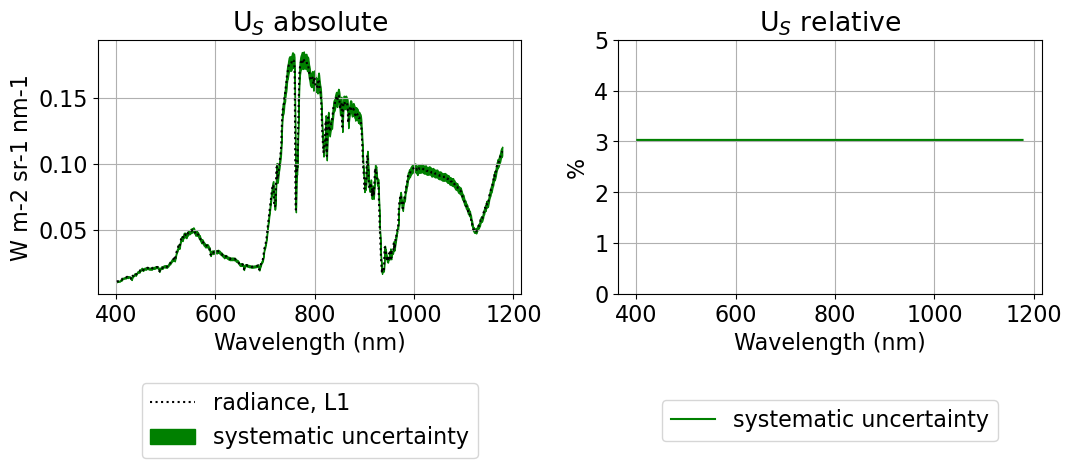

In [20]:
_, axs = plt.subplots(1, 2, figsize=(11, 4.5), tight_layout=True)

x = L1
ur = L1_us
c = 'green'
utype = 'systematic'

ax = axs[0]
ax.plot(Wvl, x, color="black", linestyle=':', label='radiance, L1')
ax.fill_between(Wvl, x - ur, x + ur, color=c, alpha=1, label=f"{utype} uncertainty")
ax.set_title(f"U$_S$ absolute")
ax.set_ylabel('W m-2 sr-1 nm-1')

ax = axs[1]
ax.plot(Wvl, ur / x * 100, color=c, label=f"{utype} uncertainty")
ax.set_title(f"U$_S$ relative")
ax.set_ylabel('%')
ax.set_ylim([0, 5])

for ax in axs:
    ax.set_xlabel("Wavelength (nm)")
    ax.grid()
    ax.legend(bbox_to_anchor=[0.5, -0.5], loc='center')

## 4-5
### total uncertainty $U_T$

[back to TOC](#TOC)

$U_T = \sqrt{U_R^2 + U_S^2}$



In [21]:
L1_ut = (L1_ur ** 2 + L1_us ** 2) ** 0.5 # total uncertainty

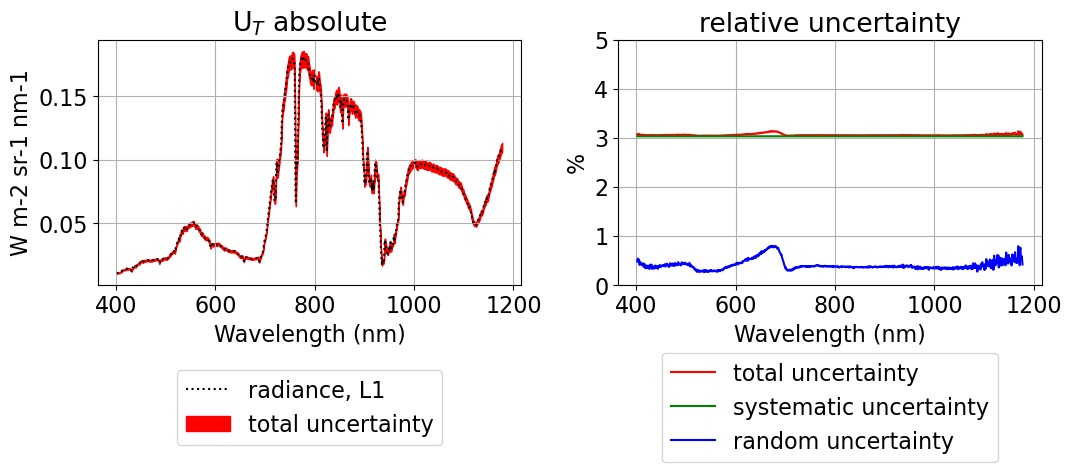

In [22]:
_, axs = plt.subplots(1, 2, figsize=(11, 4.5), tight_layout=True)

x = L1
ur = L1_ut
c = 'red'
utype = 'total'

ax = axs[0]
ax.plot(Wvl, x, color="black", linestyle=':', label='radiance, L1')
ax.fill_between(Wvl, x - ur, x + ur, color=c, alpha=1, label=f"{utype} uncertainty")
ax.set_title("U$_T$ absolute")
ax.set_ylabel('W m-2 sr-1 nm-1')

ax = axs[1]
ax.plot(Wvl, ur / x * 100, color=c, label=f"{utype} uncertainty")
ax.plot(Wvl, L1_us / x * 100, color='green', label="systematic uncertainty")
ax.plot(Wvl, L1_ur / x * 100, color='blue', label="random uncertainty")
ax.set_title(f"relative uncertainty")
ax.set_ylabel('%')
ax.set_ylim([0, 5])

for ax in axs:
    ax.set_xlabel("Wavelength (nm)")
    ax.grid()
    ax.legend(bbox_to_anchor=[0.5, -0.5], loc='center')

# 5
## Correlation and covariance matrices

[back to TOC](#TOC)

Correlation matrix is a diagnostic tool that helps identify the patterns of uncertainty and analyze their interdependence. In our case, the dependence is possible in the spectral domain.

To construct the correlation matrix of total uncertainty we have to follow four steps
1. define correlation matrices of $U_R$ and $U_S$
2. convert correlation matrices to covariance matrices
3. compute total covariance matrix (sum of radom and systematic covariances)
4. convert total covariance matrix to total correlation matrix

Correlation matrices are symmetric, meaning the elements above and below the main diagonal are the same. Yet, we will not mask any part of it


In [23]:
def plot_cor_mat(cor_mat, symbol, ax=None, cmap='RdBu_r', cbar_label='correlation coefficient', vmin=None):
    if ax is None:
        _, ax = plt.subplots()

    if vmin is not None:
        vmax = -1 * vmin
        im = ax.imshow(cor_mat, cmap=cmap, vmin=vmin, vmax=vmax)
    else:
        im = ax.imshow(cor_mat, cmap=cmap)
    plt.colorbar(im, label=cbar_label)
    ax.set_title(symbol)
    
    n_wl = Wvl.size
    ticks = ax.get_xticks()
    ticks = ticks[(ticks >= 0) & (ticks < n_wl)].astype(int)
    tick_labels = Wvl[ticks].astype(int)
    ax.set_xticks(ticks);
    ax.set_xticklabels(tick_labels)
    ax.set_xlabel("Wavelength (nm)")
    
    ticks = ax.get_yticks()
    ticks = ticks[(ticks >= 0) & (ticks < n_wl)].astype(int)
    tick_labels = Wvl[ticks].astype(int)
    ax.set_yticks(ticks);
    ax.set_yticklabels(tick_labels)
    ax.set_ylabel("Wavelength (nm)")

## 5-1
### $U_R$

[back to TOC](#TOC)

### 5-1-1
#### correlation matrix

By definition **random uncertainties** are not correlated (fully uncorrelated). 

Therefore, their correlation matrix is an identity (or unity) matrix, where diagonal elements are ones (the values are always correlated with themselves) and other elements are zeros. 

In Python the function is called `np.eye()`

*It is also possible to output correlation matrix from the `.propagate_random()` function specifying `return_corr = True`*

In [24]:
L1_ur_corr = np.eye(len(L1_ur))
L1_ur_corr.shape

(1036, 1036)

In [25]:
# L1_ur, L1_ur_corr = prop.propagate_random(calibrate,
#                                           [L0_m, dark_L0_m, cal_coef_L0],
#                                           [L0_ur, dark_L0_ur, np.zeros(len(Wvl))],
#                                           return_corr = True)  

### 5-1-2
#### covariance matrix

function help https://comet-maths.readthedocs.io/en/latest/content/generated/comet_maths.linear_algebra.matrix_conversion.convert_cov_to_corr.html#comet_maths.linear_algebra.matrix_conversion.convert_cov_to_corr


In [26]:
L1_ur_cov = punpy.convert_corr_to_cov(L1_ur_corr, L1_ur)
L1_ur_cov.shape

(1036, 1036)

### 5-1-3
#### plotting correlation and covariance matrices

notice, the range of correlation matix is [0, 1], the range of covariance matrix is in the order of 1e-7



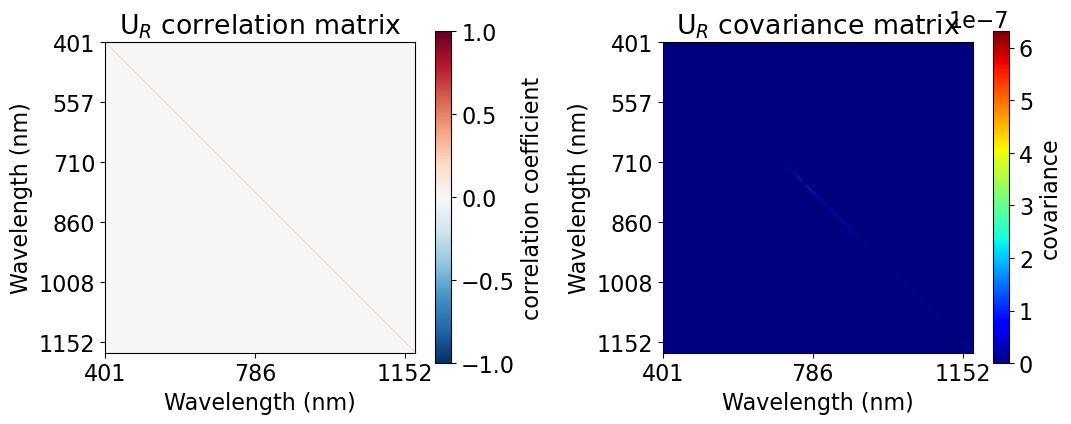

In [27]:
_, axs = plt.subplots(1, 2, figsize=(11, 4.5), tight_layout=True)

ax = axs[0]
plot_cor_mat(L1_ur_corr, 'U$_R$ correlation matrix', ax=ax, vmin=-1)

ax = axs[1]
plot_cor_mat(L1_ur_cov, 'U$_R$ covariance matrix', ax=ax, cmap='jet', cbar_label='covariance')

## 5-2
### $U_S$

[back to TOC](#TOC)
### 5-2-1
#### correlation matrix

**Systematic uncertainties** are, by definition, fully correlated. 

Therefore, correlation matrix of systematic uncertaineies is full of ones (`np.ones()`)

*It is also possible to output correlation matrix from the `.propagate_systematic()` function specifying `return_corr = True`*

In [28]:
L1_us_corr = np.ones([len(L1_us), len(L1_us)])
L1_us_corr.shape

(1036, 1036)

In [29]:
# L1_us, L1_us_corr = prop.propagate_systematic(calibrate,
#                                               [L0_m, dark_L0_m, cal_coef_L0], 
#                                               [np.zeros(1036), np.zeros(1036), cCalL_us_abs],
#                                               return_corr = True)  
# L1_us_corr.min(), L1_us_corr.max()

### 5-2-2
#### covariance matrix

In [30]:
L1_us_cov = punpy.convert_corr_to_cov(L1_us_corr, L1_us)
L1_us_cov.shape

(1036, 1036)

### 5-1-3
#### plotting correlation and covariance matrices

notice, the range of correlation matix is [0, 1], the range of covariance matrix is in the order of 1e-5



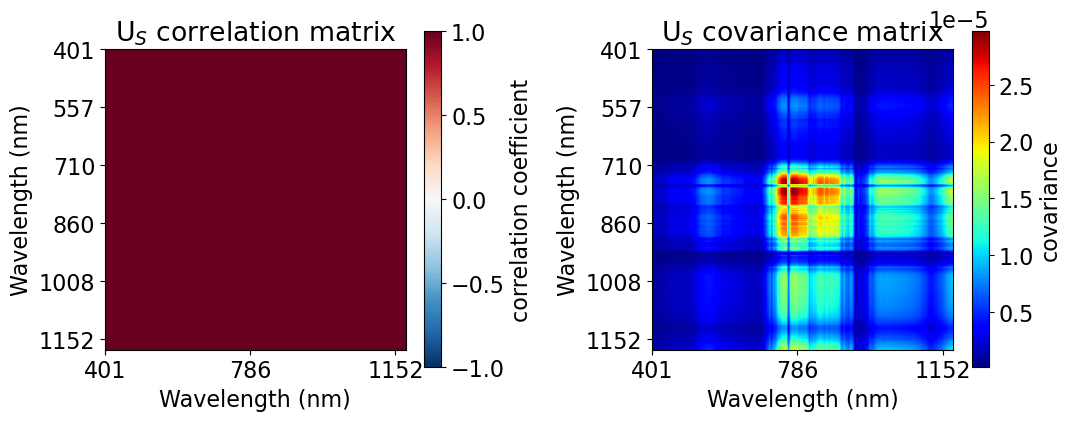

In [31]:
_, axs = plt.subplots(1, 2, figsize=(11, 4.5), tight_layout=True)

ax = axs[0]
plot_cor_mat(L1_us_corr, 'U$_S$ correlation matrix', ax=ax, vmin=-1)

ax = axs[1]
plot_cor_mat(L1_us_cov, 'U$_S$ covariance matrix', ax=ax, cmap='jet', cbar_label='covariance')

## 5-3
### Covariance matrix of total uncertainty (U$_T$)

[back to TOC](#TOC)

In [32]:
L1_cov = L1_ur_cov + L1_us_cov
L1_cov.shape

(1036, 1036)

## 5-4
### Correlation matrix of total uncertainty (U$_T$)

[back to TOC](#TOC)

Computing from covariances

function help 
https://comet-maths.readthedocs.io/en/latest/content/generated/comet_maths.linear_algebra.matrix_conversion.convert_corr_to_cov.html#comet_maths.linear_algebra.matrix_conversion.convert_corr_to_cov

In [33]:
L1_corr = punpy.correlation_from_covariance(L1_cov)
L1_corr.shape

(1036, 1036)

## 5-5
### Correlation matrix interpretation

[back to TOC](#TOC)

In total uncertainty of radiance we can see four sections
- 500-600 nm - green peak of vegetation. All bands there show the same information accross repetitions (correlation coefficient is 1)
- 670 nm - vegetation red-edge position. There the signals disagree. This is where the random uncertaintiy peaks (correlation coefficient is the lowest, 0.94)
- 970-1100 nm - water absorption spectral feature in NIR
- 1100-1200 nm - general detector degradation at the edge of the spectral resolution

The striping effects seen all over the spectrum may also be related to detector change of the instrument

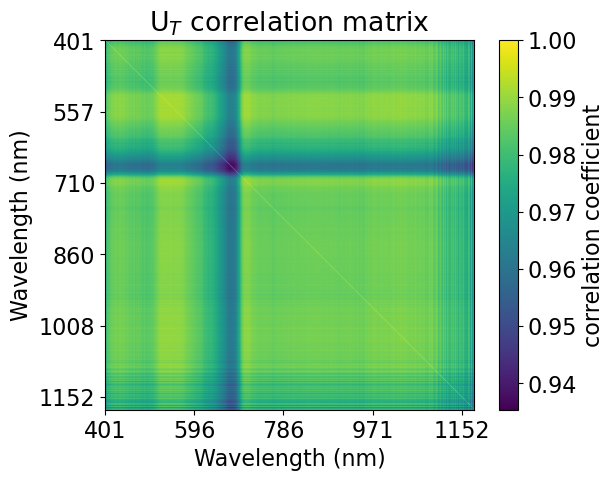

In [34]:
plot_cor_mat(L1_corr, 'U$_T$ correlation matrix', cmap='viridis')

# 6
## TASK: Repeat the steps for irradiance computation

[back to TOC](#TOC)

<span style="color:red">
    
1) propagate uncertainties for spectral irradiance (E) 
    
2) compute and analyze their correlation matrix
</span>